# Pulling rivers from OpenStreetMap (OSM)

In [22]:
import OSMPythonTools
import OSMPythonTools.api
import OSMPythonTools.overpass
from OSMPythonTools.overpass import overpassQueryBuilder
import geopandas
import shapely
import pathlib
import numpy
import matplotlib.pyplot

## Waikanae region of interest
OSM uses Latitudes and Longitudes (EPSG:4326) as its coordinate system.

In [23]:
def bbox_from_points(x0, y0, x1, y1) -> geopandas.GeoDataFrame:
    bbox_nztm2000 = geopandas.GeoDataFrame(
        geometry=[shapely.geometry.Polygon([[x0, y0],
                                            [x1, y0],
                                            [x1, y1],
                                            [x0, y1]])],
                                           crs='EPSG:2193')
    return bbox_nztm2000

In [24]:
def query_in_bbox(x0, y0, x1, y1) -> tuple:
    print(f"Is x1/y1 greater than x0/y0? dx={x1-x0}, and dy={y1-y0}")

    bbox_nztm2000 = bbox_from_points(x0=x0, y0=y0, x1=x1, y1=y1)
    bbox_lat_long = bbox_nztm2000.to_crs('EPSG:4326')
    query = overpassQueryBuilder(bbox=[bbox_lat_long.bounds.miny[0],
                                       bbox_lat_long.bounds.minx[0],
                                       bbox_lat_long.bounds.maxy[0],
                                       bbox_lat_long.bounds.maxx[0]], 
                                 elementType='way', selector='waterway',
                                 out='body', includeGeometry=True)
    print(query)
    overpass = OSMPythonTools.overpass.Overpass()
    rivers = overpass.query(query)
    return rivers, bbox_nztm2000

In [25]:
def query_from_bbox(bbox_nztm2000) -> tuple:
    print(f"Is x1/y1 greater than x0/y0? dx={x1-x0}, and dy={y1-y0}")

    bbox_lat_long = bbox_nztm2000.to_crs('EPSG:4326')
    query = overpassQueryBuilder(bbox=[bbox_lat_long.bounds.miny[0],
                                       bbox_lat_long.bounds.minx[0],
                                       bbox_lat_long.bounds.maxy[0],
                                       bbox_lat_long.bounds.maxx[0]], 
                                 elementType='way', selector='waterway',
                                 out='body', includeGeometry=True)
    print(query)
    overpass = OSMPythonTools.overpass.Overpass()
    rivers = overpass.query(query)
    return rivers, bbox_nztm2000

In [26]:
def drains_from_rivers(rivers):
    element_dict = {
        'geometry': [],
        'OSM_id': [],
        'waterway': [],
        'tunnel': [],
    }

    for element in rivers.elements():
        element_dict['geometry'].append(element.geometry())
        element_dict['OSM_id'].append(element.id())
        element_dict['waterway'].append(element.tags()['waterway'])
        element_dict['tunnel'].append('tunnel' in element.tags().keys())
    drains_df = geopandas.GeoDataFrame(element_dict, crs='EPSG:4326').to_crs('EPSG:2193')
    return drains_df

# Compare bbox of the first two queries

<AxesSubplot:>

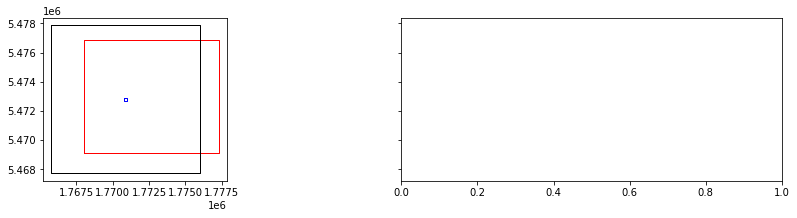

In [27]:
x0 = 1768073
y0 = 5469138
x1 = 1777290
y1 = 5476849 # origional
bbox_original = bbox_from_points(x0=x0, y0=y0, x1=x1, y1=y1)
x0 = 1770797
y0 = 5472879
x1 = 1770969
y1 = 5472707 # drains test
bbox_drain_test = bbox_from_points(x0=x0, y0=y0, x1=x1, y1=y1)
dxy=5000
bbox_drains_bigger = bbox_from_points(x0=x0-dxy, y0=y0+dxy, x1=x1+dxy, y1=y1-dxy)
f, axs = matplotlib.pyplot.subplots(1, 2, sharey=True, figsize=(15,3))
bbox_original.plot(ax=axs[0], facecolor="none", edgecolor='r')
bbox_drain_test.plot(ax=axs[0], facecolor="none", edgecolor='b')
bbox_drains_bigger.plot(ax=axs[0], facecolor="none", edgecolor='k')

# A query that works

Is x1/y1 greater than x0/y0? dx=9217, and dy=7711
(way[waterway](-40.91160630219117,174.99364670676297,-40.840243712602486,175.10510715718377);); out body geom;
Is x1/y1 greater than x0/y0? dx=9217, and dy=-7711
(way[waterway](-40.91160630219117,174.99364670676297,-40.840243712602486,175.10510715718377);); out body geom;
Is x1/y1 greater than x0/y0? dx=-9217, and dy=7711
(way[waterway](-40.91160630219117,174.99364670676297,-40.840243712602486,175.10510715718377);); out body geom;


<AxesSubplot:>

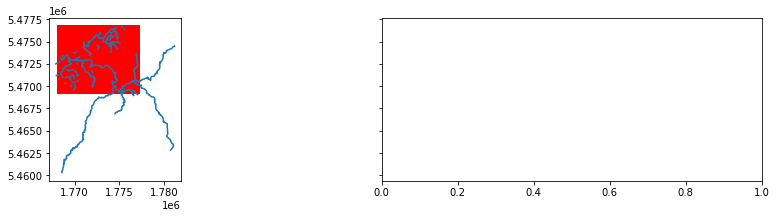

In [28]:
x0 = 1768073
y0 = 5469138
x1 = 1777290
y1 = 5476849 # origional
bbox_original = bbox_from_points(x0=x0, y0=y0, x1=x1, y1=y1)
rivers, bbox = query_from_bbox(bbox_original)
drains = drains_from_rivers(rivers)
rivers, bbox = query_in_bbox(x0=x0, y0=y1, x1=x1, y1=y0)
drains = drains_from_rivers(rivers)
rivers, bbox = query_in_bbox(x0=x1, y0=y0, x1=x0, y1=y1)
drains = drains_from_rivers(rivers)
f, axs = matplotlib.pyplot.subplots(1, 2, sharey=True, figsize=(15,3))
bbox.plot(ax=axs[0], color='r')
drains.plot(ax=axs[0])

In [29]:
x0 = 1768073
y0 = 5469138
x1 = 1777290
y1 = 5476849 # origional
rivers, bbox = query_in_bbox(x0=x0, y0=y0, x1=x1, y1=y1)
rivers, bbox = query_in_bbox(x0=x0, y0=y1, x1=x1, y1=y0)
rivers, bbox = query_in_bbox(x0=x1, y0=y0, x1=x0, y1=y1)

Is x1/y1 greater than x0/y0? dx=9217, and dy=7711
(way[waterway](-40.91160630219117,174.99364670676297,-40.840243712602486,175.10510715718377);); out body geom;
Is x1/y1 greater than x0/y0? dx=9217, and dy=-7711
(way[waterway](-40.91160630219117,174.99364670676297,-40.840243712602486,175.10510715718377);); out body geom;
Is x1/y1 greater than x0/y0? dx=-9217, and dy=7711
(way[waterway](-40.91160630219117,174.99364670676297,-40.840243712602486,175.10510715718377);); out body geom;


# A query that doesn't work

The following string works fine as a query in geofabrics
`(way[waterway](-40.87891130456266,175.027028835165,-40.87732694117711,175.029116224636);); out body geom;`

In [30]:
import OSMPythonTools.overpass; overpass = OSMPythonTools.overpass.Overpass(); 
rivers = overpass.query('(way[waterway](-40.87891130456266,175.027028835165,-40.87732694117711,175.029116224636);); out body geom;')

[overpass] downloading data: [timeout:25][out:json];(way[waterway](-40.87891130456266,175.027028835165,-40.87732694117711,175.029116224636);); out body geom;


Exception: [overpass] could not fetch or interpret status of the endpoint

In [ ]:
x0 = 1770797
y0 = 5472879
x1 = 1770969
y1 = 5472707 # drains test
dxy=5000
bbox_original = bbox_from_points(x0=x0, y0=y0, x1=x1, y1=y1)
rivers, bbox = query_from_bbox(bbox_original)
rivers, bbox = query_in_bbox(x0=x0-dxy, y0=y1-dxy, x1=x1+dxy, y1=y0+dxy) # make bigger
rivers, bbox = query_in_bbox(x0=x0-dxy, y0=y0+dxy, x1=x1+dxy, y1=y1-dxy) # make bigger

In [ ]:
x0 = 1770797
y0 = 5472879
x1 = 1770969
y1 = 5472707 # drains test
bbox_nztm2000 = geopandas.GeoDataFrame(geometry=[shapely.geometry.Polygon([[x0, y0], [x1, y0], [x1, y1], [x0, y1]])],
                                       crs='EPSG:2193')
bbox_nztm2000.to_file(r"C:\Users\pearsonra\Documents\data\debug_tests\jupyter_notebook_error_1.geojson")
bbox_lat_long = bbox_nztm2000.to_crs('EPSG:4326')
query = overpassQueryBuilder(bbox=[bbox_lat_long.bounds.miny[0],
                                   bbox_lat_long.bounds.minx[0],
                                   bbox_lat_long.bounds.maxy[0],
                                   bbox_lat_long.bounds.maxx[0]], 
                             elementType='way', selector='waterway',
                             out='body', includeGeometry=True)
overpass = OSMPythonTools.overpass.Overpass()
rivers = overpass.query(query)

In [ ]:
x0 = 1768072; y0 = 5473816; x1 = 1769545; y1 = 5472824; 
catchment = shapely.geometry.Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)]); 
catchment = geopandas.GeoSeries([catchment], crs='EPSG:2193'); 
#catchment = catchment.set_crs(2193); 
bbox_lat_long = catchment.to_crs("EPSG:4326"); 
query = OSMPythonTools.overpass.overpassQueryBuilder(bbox=[bbox_lat_long.bounds.miny[0],
                                                           bbox_lat_long.bounds.minx[0],
                                                           bbox_lat_long.bounds.maxy[0],
                                                           bbox_lat_long.bounds.maxx[0]],
                                                     elementType="way", selector="waterway",
                                                     out="body", includeGeometry=True); 
overpass = OSMPythonTools.overpass.Overpass();
rivers = overpass.query(query) # problem

In [ ]:
x0 = 1768073
y0 = 5469138
x1 = 1777290
y1 = 5476849
print(x0-x1)
print(y0-y1)

In [ ]:
x0 = 1770797; y0 = 5472879; x1 = 1770969; y1 = 5472707;
print(x0-x1)
print(y0-y1)

In [ ]:
x0 = 1768073
y0 = 5469138
x1 = 1777290
y1 = 5476849
bbox_nztm2000 = geopandas.GeoDataFrame(geometry=[shapely.geometry.Polygon([[x0, y0], [x1, y0], [x1, y1], [x0, y1]])],
                                       crs='EPSG:2193')
bbox_lat_long = bbox_nztm2000.to_crs('EPSG:4326')

## OSM basic structure
There are several parts to the OSM structure that can be used to access individual OSM objects/elements (i.e. a bus top, highway centreline, lake, etc). We will refer to OSM objects as elements, which is the term used by the Python library we are using.

These include the:
* Element ID - these are unique with in each object type
* Element Type - defines the data model structure of the object (see below)
* Element Tag - there are various predefined tags that can be used to describe an object/element.

### OSMPythonTools
OSMPythonTools is an extensive Python wrapper for accessing OSM data. The `OSMPythonTools.overpass.Overpass` class takes care of sending queries and retireving data from OSM, while the `OSMPythonTools.overpass.overpassQueryBuilder` is a class for creating a query for OSM objects in an area. The queries can specify objects to collect by ID, Element Type, Tag, and BBox search.

The `overpassQueryBuilder` has the following generally form:
```
query = overpassQueryBuilder(bbox=[south,
                                   west,
                                   north,
                                   east], 
                             elementType=['nodes', 'way'], selector='"waterway"="river"',
                             out='body', includeGeometry=True)
```

#### Element Type
The **elementType** is the name used by the `overpassQueryBuilder` to define the element type of an object. This can either be a single string, or a list of strings, depending if one or multiple types should be retrieved.

The element type define the OSM data model component of each OSM object. There are three basic options: nodes, way and relation. These can be losely defined as:
* nodes - are points on the maps (in latitude and longitude)
* way - on the other hand is a ordered list of nodes, which could correspond to a street or the outline of a house.
* relation - which is also an ordered list containing either nodes, ways or even other relations. It is used to model logical or geographic relationships between objects.

#### Element Tag
Various tags can be added to an OSM object. These can be specified in the `overpassQueryBuilder` by the **selector** keyword. This can be a string or list. Only objects with these tags with be retrieved. This can be a list or string. If it is a list only objects with all of those tags with be retrived. The page defines all OSM tags, and while the [waterways page](https://wiki.openstreetmap.org/wiki/Waterways) describes waterway related tags. 

# Code example
## Construct query

In [ ]:
query = overpassQueryBuilder(bbox=[bbox_lat_long.bounds.miny[0],
                                   bbox_lat_long.bounds.minx[0],
                                   bbox_lat_long.bounds.maxy[0],
                                   bbox_lat_long.bounds.maxx[0]], 
                             elementType='way', selector='waterway',
                             out='body', includeGeometry=True)

## Perform query

In [ ]:
overpass = OSMPythonTools.overpass.Overpass()
rivers = overpass.query(query)

## Extract geometries

In [ ]:
element_dict = {
    'geometry': [],
    'OSM_id': [],
    'waterway': [],
    'tunnel': [],
}

for element in rivers.elements():
    element_dict['geometry'].append(element.geometry())
    element_dict['OSM_id'].append(element.id())
    element_dict['waterway'].append(element.tags()['waterway'])
    element_dict['tunnel'].append('tunnel' in element.tags().keys())
drains_df = geopandas.GeoDataFrame(element_dict, crs='EPSG:4326').to_crs('EPSG:2193')

In [ ]:
f, axs = matplotlib.pyplot.subplots(1, 2, sharey=True, figsize=(15,6))
drains_df[(drains_df['waterway'] != 'river') & (drains_df['tunnel'] == False)].clip(bbox_nztm2000).plot(ax=axs[0])
drains_df[(drains_df['waterway'] != 'river') & (drains_df['tunnel'])].clip(bbox_nztm2000).plot(ax=axs[1])
axs[0].set_title("All drains"); axs[1].set_title("All culverts/tunnels");

In [ ]:
drain_width = 5
drain_polygon = drains_df[drains_df.geometry.type == "LineString"].buffer(drain_width)
drain_polygon = geopandas.GeoDataFrame(
    geometry=[shapely.ops.unary_union(drain_polygon.geometry.array)],
    crs=drain_polygon.crs,
)
drain_polygon = drain_polygon.clip(bbox_nztm2000)
drain_polygon.plot()

In [ ]:
'''drains_df[drains_df.geometry.type == "LineString"].to_file(
    r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae_new_lidar\caches\drains_5m\drains.geojson")'''